## Loading the dataset

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## ✅ Exercise 1: Data Exploration and Cleaning

This section covers the initial loading, exploration, and quality checks for the SuperStore dataset.

In [40]:
df = pd.read_csv('../datasets/SuperStoreUS.csv')
pd.set_option('display.max_columns', None)

### Convert date column to proper datetime

In [41]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

## Identify and handle any outliers in sales and profits

### ⚠️ Outlier Detection
Using the IQR method to identify outliers in numeric columns (excluding ID fields).

In [42]:
ex_columns = ['Row ID', 'Customer ID', 'Postal Code', 'Quantity ordered new', 'Order ID']
for col in df.select_dtypes(include='number'):
    if col not in ex_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
        print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")

Discount: 2 outliers (0.1%)
Unit Price: 176 outliers (9.0%)
Shipping Cost: 224 outliers (11.5%)
Product Base Margin: 0 outliers (0.0%)
Profit: 426 outliers (21.8%)
Sales: 251 outliers (12.9%)


### outliers in sales column

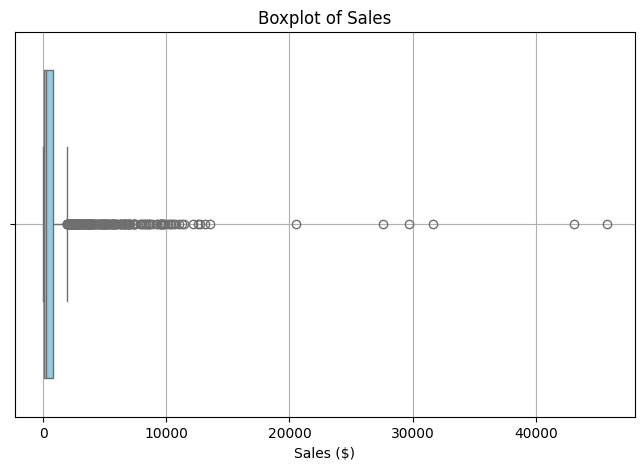

In [43]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Sales'], color='skyblue')
plt.title('Boxplot of Sales')
plt.xlabel('Sales ($)')
plt.grid(True)
plt.show()


### outliers in profit column

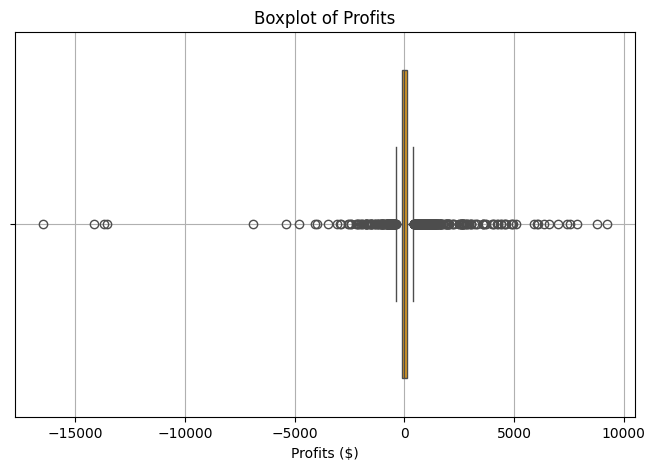

In [44]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Profit'], color='orange')
plt.title('Boxplot of Profits')
plt.xlabel('Profits ($)')
plt.grid(True)
plt.show()

In [45]:
def flag_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[f'{column}_outlier'] = (df[column] < lower_bound) | (df[column] > upper_bound)
    return df

# Flag outliers instead of removing them
df = flag_outliers(df, 'Sales')
df = flag_outliers(df, 'Profit')

### 🔍 Dataset Overview
We begin by checking the number of rows and columns, memory usage, and an initial view of the dataset.

In [46]:
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Rows: 1951
Columns: 27
Memory Usage: 1.59 MB


### 📌 Missing Values
We check for missing values in each column.

In [47]:
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
print(missing[missing > 0].to_frame("Missing Count").join(missing_pct.to_frame("Missing %")))

                     Missing Count  Missing %
Product Base Margin             16   0.820092


### 🔁 Duplicate Rows and Data Types

In [48]:
duplicates = df.duplicated().sum()
print(f"Duplicate Rows: {duplicates} ({duplicates/len(df)*100:.1f}%)")

print(df.dtypes.value_counts())


Duplicate Rows: 0 (0.0%)
object            12
float64            6
int64              5
datetime64[ns]     2
bool               2
Name: count, dtype: int64


### ➖ Zero and Negative Values

In [49]:
for col in ['Sales', 'Profit', 'Quantity ordered new']:
    zero_count = (df[col] == 0).sum()
    neg_count = (df[col] < 0).sum()
    print(f"{col}: {zero_count} zeros, {neg_count} negatives")


Sales: 0 zeros, 0 negatives
Profit: 0 zeros, 955 negatives
Quantity ordered new: 0 zeros, 0 negatives


### 🔤 Unique Value Counts (Categorical Columns)

In [50]:
for col in df.select_dtypes(include='object'):
    unique = df[col].nunique()
    print(f"{col}: {unique} unique values")


Order Priority: 5 unique values
Customer Name: 1130 unique values
Ship Mode: 3 unique values
Customer Segment: 4 unique values
Product Category: 3 unique values
Product Sub-Category: 17 unique values
Product Container: 7 unique values
Product Name: 913 unique values
Country: 1 unique values
Region: 4 unique values
State or Province: 49 unique values
City: 869 unique values


### 📅 Invalid Dates and Business Rule Violations


In [51]:
invalid_dates = df[df['Ship Date'] < df['Order Date']]
print(f"Ship date before order date: {len(invalid_dates)} records")

violations = df[(df['Profit'] > df['Sales']) & (df['Sales'] > 0)]
print(f"Records with Profit > Sales: {len(violations)}")

Ship date before order date: 0 records
Records with Profit > Sales: 70


# Exercise 2

### 📌 Step 1: Calculate Key Sales Metrics

In [52]:
# ✅ Total Sales
Total_sales = df['Sales'].sum()

# ✅ Total Profit
Total_profit = df['Profit'].sum()

# ✅ Average Order Value (AOV)
unique_orders = df['Order ID'].nunique()
Average_order_value = Total_sales/unique_orders

print(f'the average order value: ${Average_order_value:.2f}')


the average order value: $1409.73


### 📅 Step 2: Analyze Sales Trends by Month and Year

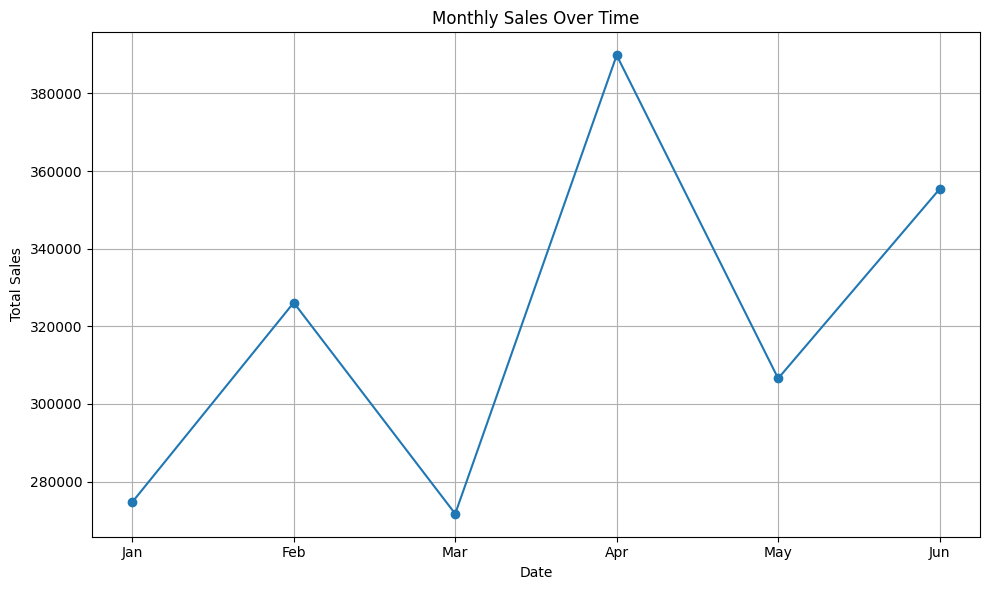

In [53]:
# ✅ Convert Order Date to datetime if not already
# df['Order Date'] = pd.to_datetime(df['Order Date'])

# ✅ Extract year and month from Order Date
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.strftime('%b')

# ✅ Group by Year and Month and calculate total sales
monthly_sales = df.groupby(['Order Year', 'Order Month'])['Sales'].sum().reset_index()
monthly_sales['Month Date'] = pd.to_datetime(monthly_sales['Order Year'].astype(str) + '-' + monthly_sales['Order Month'], format='%Y-%b')
monthly_sales = monthly_sales.sort_values('Month Date')

# ✅ Plot a line chart of monthly sales trend
# Use matplotlib or seaborn for line plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['Order Month'], monthly_sales['Sales'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


### 🏆 Step 3: Identify Top 10 Best-Selling Products

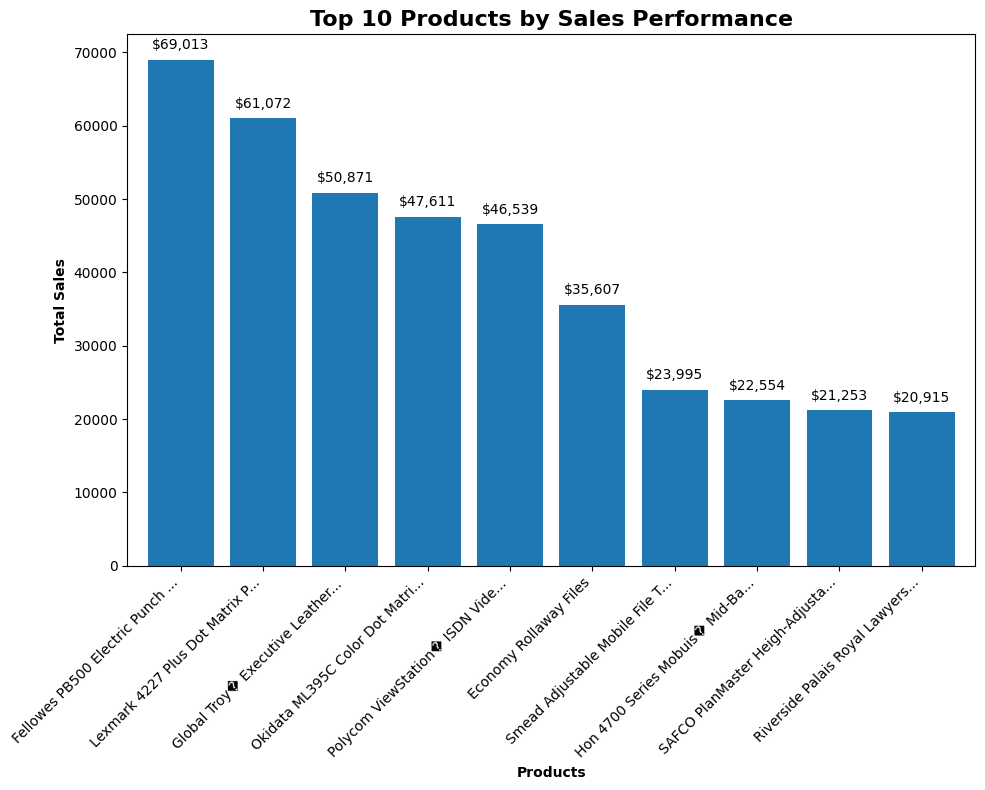

In [54]:
# Simple truncation function
def truncate_name(name):
    return name[:30] + '...' if len(name) > 30 else name

# For TOP 10 products:
Top_10_products = df.groupby(['Product Name'])['Sales'].sum().sort_values(ascending=False).head(10)

Top_10_products.index = [truncate_name(name) for name in Top_10_products.index]

plt.figure(figsize=(10, 8))
Top_10_products.plot(kind='bar', width=0.8)
plt.title('Top 10 Products by Sales Performance', fontsize=16, fontweight='bold')
plt.xlabel('Products', fontweight='bold')
plt.ylabel('Total Sales', fontweight='bold')
plt.xticks(rotation=45, ha='right')

for i, value in enumerate(Top_10_products.values):
    plt.text(i, value + 1000, f'${value:,.0f}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### 🌍 Step 4: Compare Sales Performance Across Regions

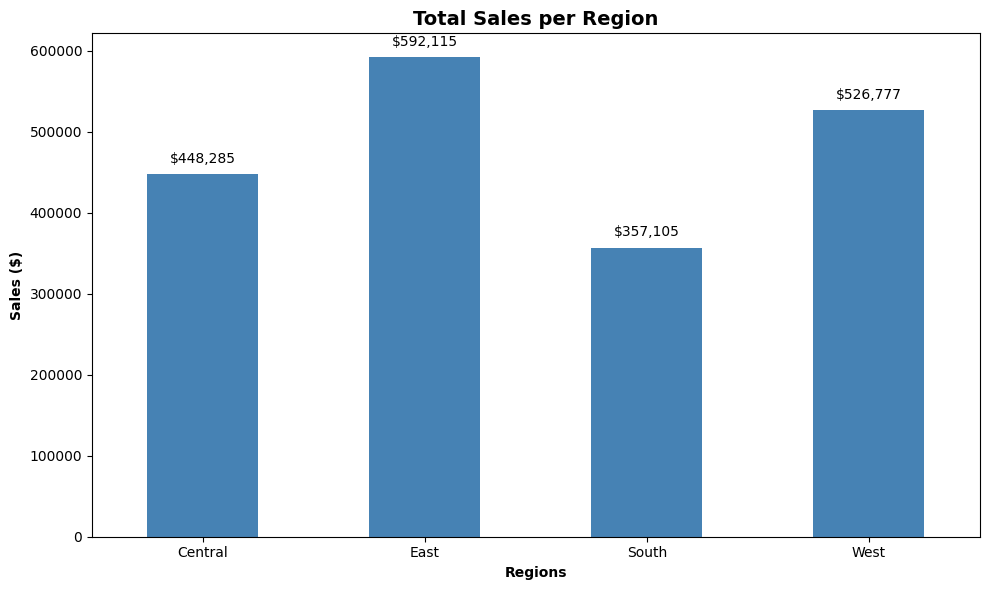

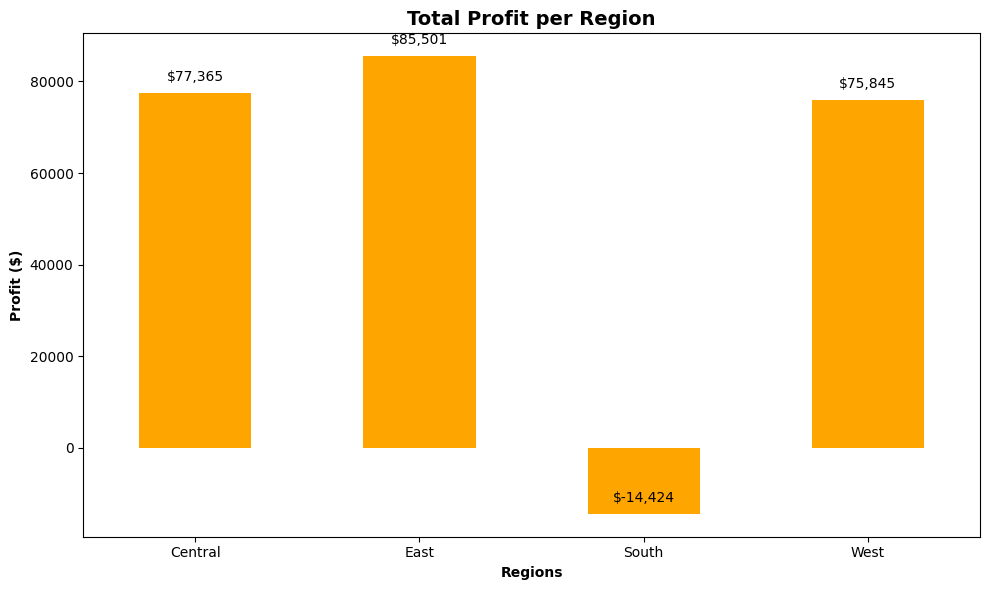

In [55]:
# ✅ Group by Region and calculate total Sales and Profit
sales_per_region = df.groupby('Region')['Sales'].sum()
profit_per_region = df.groupby('Region')['Profit'].sum()
# ✅ Create a bar chart comparing regions
# Improved version with consistent styling
plt.figure(figsize=(10, 6))
sales_per_region.plot(kind='bar', color='steelblue')
plt.title('Total Sales per Region', fontsize=14, fontweight='bold')
plt.xlabel('Regions', fontweight='bold')
plt.ylabel('Sales ($)', fontweight='bold')
plt.xticks(rotation='horizontal')
for i, value in enumerate(sales_per_region.values):
    plt.text(i, value + 10000, f'${value:,.0f}', 
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
profit_per_region.plot(kind='bar', color='orange')
plt.title('Total Profit per Region', fontsize=14, fontweight='bold')
plt.xlabel('Regions', fontweight='bold')
plt.ylabel('Profit ($)', fontweight='bold')
plt.xticks(rotation='horizontal')
for i, value in enumerate(profit_per_region.values):
    plt.text(i, value + 2000, f'${value:,.0f}', 
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### 📊 Step 5: Visualize Sales Trends

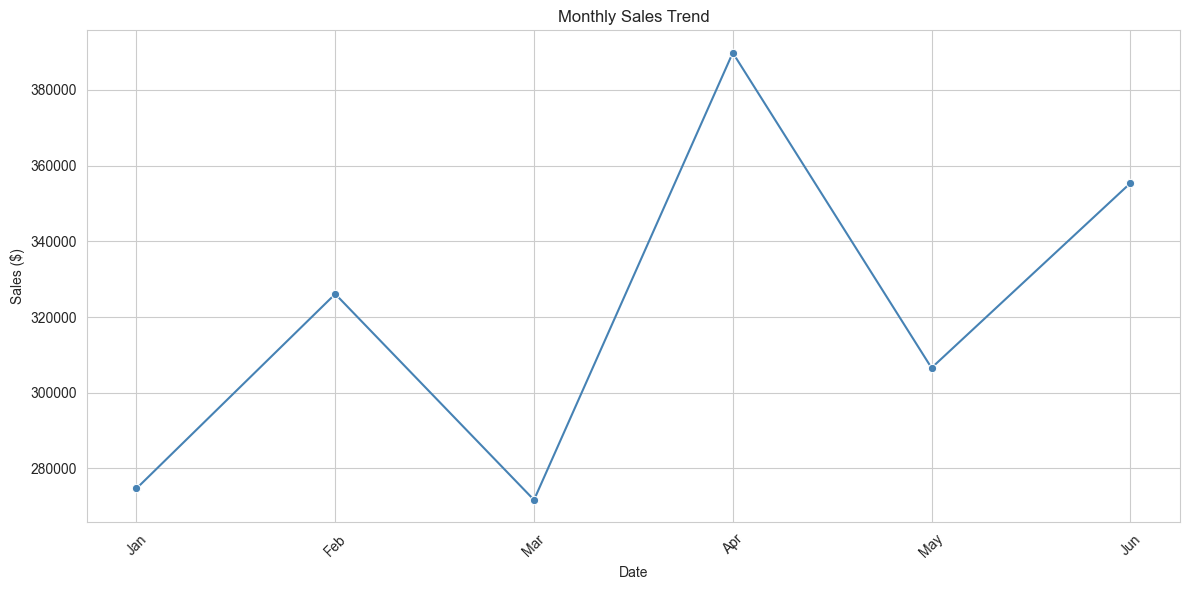

In [67]:
# monthly_sales
monthly_sales = df.groupby(['Order Year', 'Order Month'])['Sales'].sum().reset_index()
# monthly_sales['YearMonth'] = pd.to_datetime(monthly_sales['Order Year'].astype(str) + '-' + monthly_sales['Order Month'].astype(str) + '-01')
monthly_sales['Month Date'] = pd.to_datetime(monthly_sales['Order Year'].astype(str) + '-' + monthly_sales['Order Month'], format='%Y-%b')
monthly_sales = monthly_sales.sort_values('Month Date')

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='Order Month', y='Sales', marker='o', color='steelblue')
plt.title('Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_15244\2706667246.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_sales.index, y=region_sales.values, palette='Blues_d')


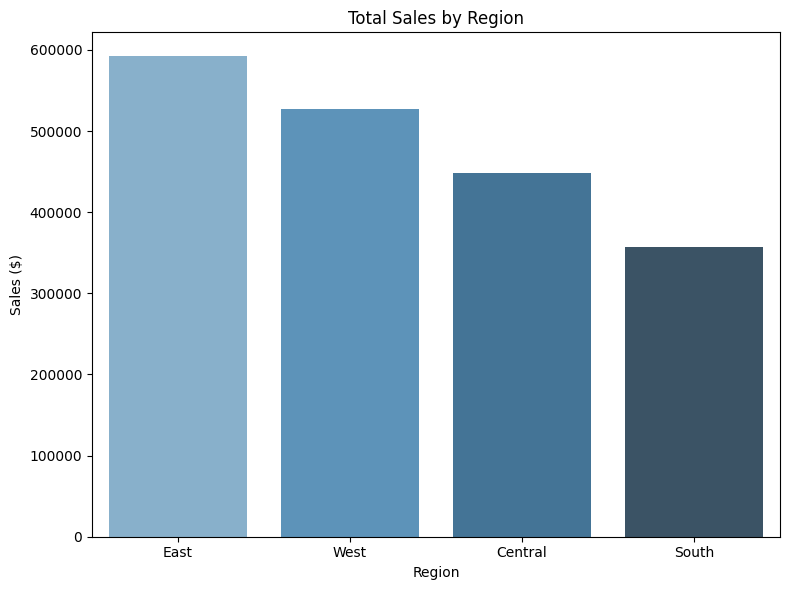

In [57]:
# Bar chart: Total sales by region
region_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=region_sales.index, y=region_sales.values, palette='Blues_d')
plt.title('Total Sales by Region')
plt.ylabel('Sales ($)')
plt.xlabel('Region')
plt.tight_layout()
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_15244\1985821961.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_products.index, x=top_products.values, palette='viridis')


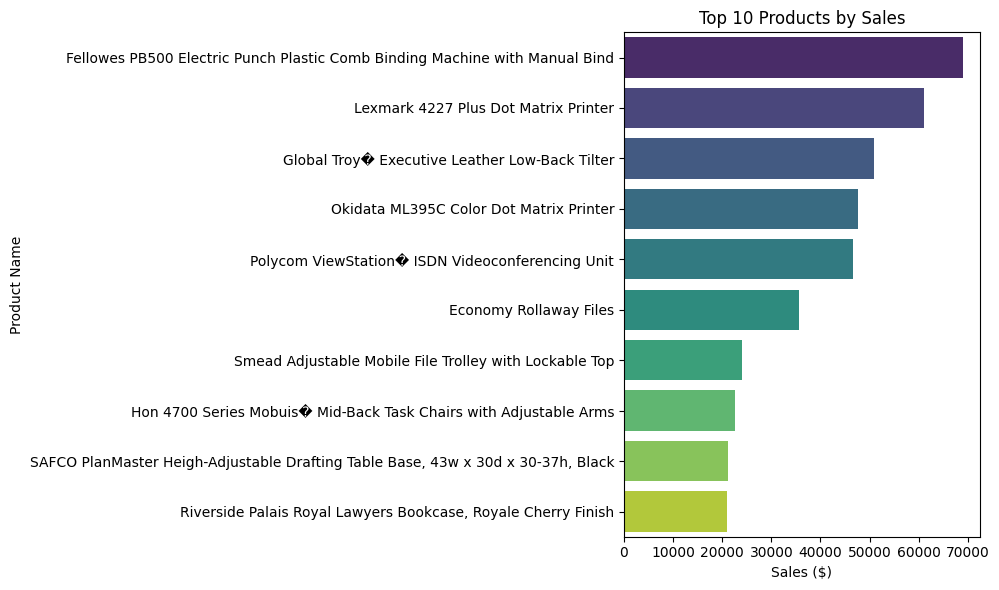

In [58]:
# Bar chart: Top 10 products by sales
top_products = df.groupby('Product Name')['Sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(y=top_products.index, x=top_products.values, palette='viridis')
plt.title('Top 10 Products by Sales')
plt.xlabel('Sales ($)')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

## ✅ Exercise 3: Customer Segmentation Analysis

> **Business Question:**
> *"Who are our most valuable customers and segments?"*

### 🔹 Step 1: Analyze sales and profit by customer segment

In [59]:
# Group data by 'Customer Segment' and summarize total Sales and Profit
customer_segment_pivot = pd.pivot_table(df, 
               values=['Sales', 'Profit'], 
               index='Customer Segment', 
               aggfunc=['sum', 'mean']).sort_values(('sum', 'Profit'), ascending=False)

customer_segment_pivot


# Optionally calculate average sales/profit per order or customer

sum                   mean             
                        Profit      Sales      Profit        Sales
Customer Segment                                                  
Small Business    65514.159691  400237.50  169.287234  1034.205426
Corporate         54444.191002  657784.53   79.596770   961.673289
Home Office       54433.520869  464481.04  115.816002   988.257532
Consumer          49894.990273  401778.37  121.695098   979.947244

### 🔹 Step 2: Calculate Customer Lifetime Value (CLV) for top customers

In [60]:
# Group data by 'Customer ID' or 'Customer Name'
top_customer = df.groupby(['Customer ID', 'Customer Name'])[['Sales', 'Profit']].sum()
top_customer['Profit_Margin'] = (top_customer['Profit'] / top_customer['Sales']) * 100

# Sum total Sales and Profit per customer
top_customer_by_profit = top_customer.sort_values(by='Profit', ascending=False).head(10)
top_customer_by_sales = top_customer.sort_values(by='Sales', ascending=False).head(10)
top_customer_by_margin = top_customer.sort_values(by='Profit_Margin', ascending=False)
most_orders = df.groupby(['Customer ID', 'Customer Name']).size().sort_values(ascending=False)

# Sort by top customers based on CLV
# Calculate CLV (Customer Lifetime Value)
# CLV can be calculated in different ways. Here are common approaches:

# Method 1: Simple CLV = Total Revenue per Customer
top_customer['CLV_Simple'] = top_customer['Sales']

# Method 2: CLV considering profit margin
top_customer['CLV_Profit'] = top_customer['Profit']

# Method 3: More sophisticated CLV = (Average Order Value × Purchase Frequency × Profit Margin × Customer Lifespan)
# First, let's calculate components
customer_metrics = df.groupby(['Customer ID', 'Customer Name']).agg({
    'Sales': ['sum', 'mean', 'count'],  # Total sales, avg order value, frequency
    'Profit': 'sum',
    'Order ID': 'nunique'  # Number of unique orders
}).round(2)

# Flatten column names
customer_metrics.columns = ['Total_Sales', 'Avg_Order_Value', 'Order_Count', 'Total_Profit', 'Unique_Orders']

# Calculate profit margin per customer
customer_metrics['Profit_Margin_Pct'] = (customer_metrics['Total_Profit'] / customer_metrics['Total_Sales']) * 100

# Assuming average customer lifespan (you might have actual data for this)
avg_customer_lifespan_months = 12  # Assume 12 months

# Calculate CLV using a more comprehensive formula
customer_metrics['CLV_Comprehensive'] = (
    customer_metrics['Avg_Order_Value'] * 
    customer_metrics['Order_Count'] * 
    (customer_metrics['Profit_Margin_Pct'] / 100) * 
    avg_customer_lifespan_months
)

# Sort by CLV
top_customer_by_clv = customer_metrics.sort_values(by='CLV_Comprehensive', ascending=False).head(10)

print(f"Top customer by CLV: {top_customer_by_clv.index[0][1]} with CLV of ${top_customer_by_clv.iloc[0]['CLV_Comprehensive']:,.2f}")
# Direct approach to get just the top customer info


print(f"Customer with most orders: {most_orders.index[0][1]} with {most_orders.iloc[0]} orders")
print(f"Top customer by profit margin: {top_customer_by_margin.index[0][1]} with {top_customer_by_margin.iloc[0]['Profit_Margin']:.2f}% margin")
print(f"Top customer by profit: {top_customer_by_profit.index[0][1]} with ${top_customer_by_profit.iloc[0]['Profit']:,.2f} in profits")
print(f"Top customer by sales: {top_customer_by_sales.index[0][1]} with ${top_customer_by_sales.iloc[0]['Sales']:,.2f} in sales")
print(f"Top customer by CLV: {top_customer_by_clv.index[0][1]} with CLV of ${top_customer_by_clv.iloc[0]['CLV_Comprehensive']:,.2f}")

Top customer by CLV: Richard McClure with CLV of $111,604.08
Customer with most orders: Jenny Gold with 9 orders
Top customer by profit margin: Juan Gold with 3347.11% margin
Top customer by profit: Richard McClure with $9,300.34 in profits
Top customer by sales: Kristine Connolly with $50,475.31 in sales
Top customer by CLV: Richard McClure with CLV of $111,604.08


### 🔹 Step 3: Identify the most profitable customer segments

In [61]:
# Reuse Step 1 data and compute profit margin: Profit / Sales per segment
profitable_segment = df.groupby('Customer Segment')[['Sales', 'Profit']].sum()
profitable_segment['Profit Margin'] = ((profitable_segment['Profit'] / profitable_segment['Sales']) * 100).round(2)

# Sort to see which segments have the highest margins
profitable_segment.sort_values(by='Profit Margin', ascending=False)

,Sales,Profit,Profit Margin
Customer Segment,,,
Small Business,400237.50,65514.159691,16.37
Consumer,401778.37,49894.990273,12.42
Home Office,464481.04,54433.520869,11.72
Corporate,657784.53,54444.191002,8.28


### 🔹 Step 4: Analyze purchase frequency and average order size by segment

                  Order ID      Sales  Average Order Size
Customer Segment                                         
Small Business         263  400237.50         1521.815589
Corporate              474  657784.53         1387.731076
Home Office            335  464481.04         1386.510567
Consumer               294  401778.37         1366.593095


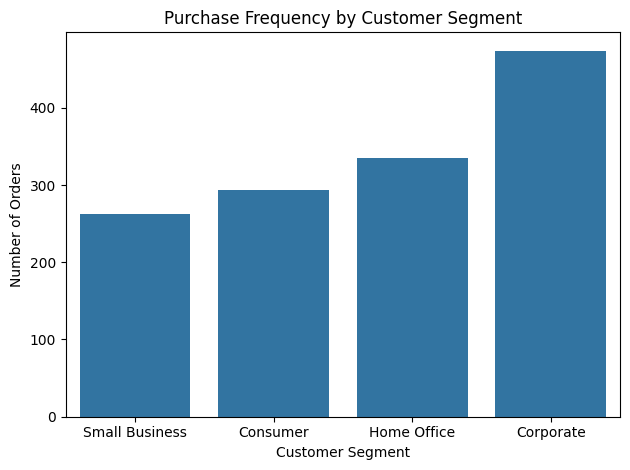

In [62]:
# Count number of unique orders per segment (purchase frequency)
segment_analysis = df.groupby('Customer Segment').agg({
    'Order ID': 'nunique',
    'Sales': 'sum'
})

# Calculate average order size: total sales / number of orders
segment_analysis['Average Order Size'] = (segment_analysis['Sales'] / segment_analysis['Order ID'])

print(segment_analysis.sort_values(by='Average Order Size', ascending=False))

purchase_frequency = segment_analysis.sort_values('Order ID').index.tolist()

sns.barplot(data=segment_analysis.reset_index(),x='Customer Segment', y='Order ID',
            order=purchase_frequency)
plt.title('Purchase Frequency by Customer Segment')
plt.ylabel('Number of Orders')
plt.xlabel('Customer Segment')
plt.tight_layout()
plt.show()


### 🔹 Step 5: Create customer segment profitability dashboard

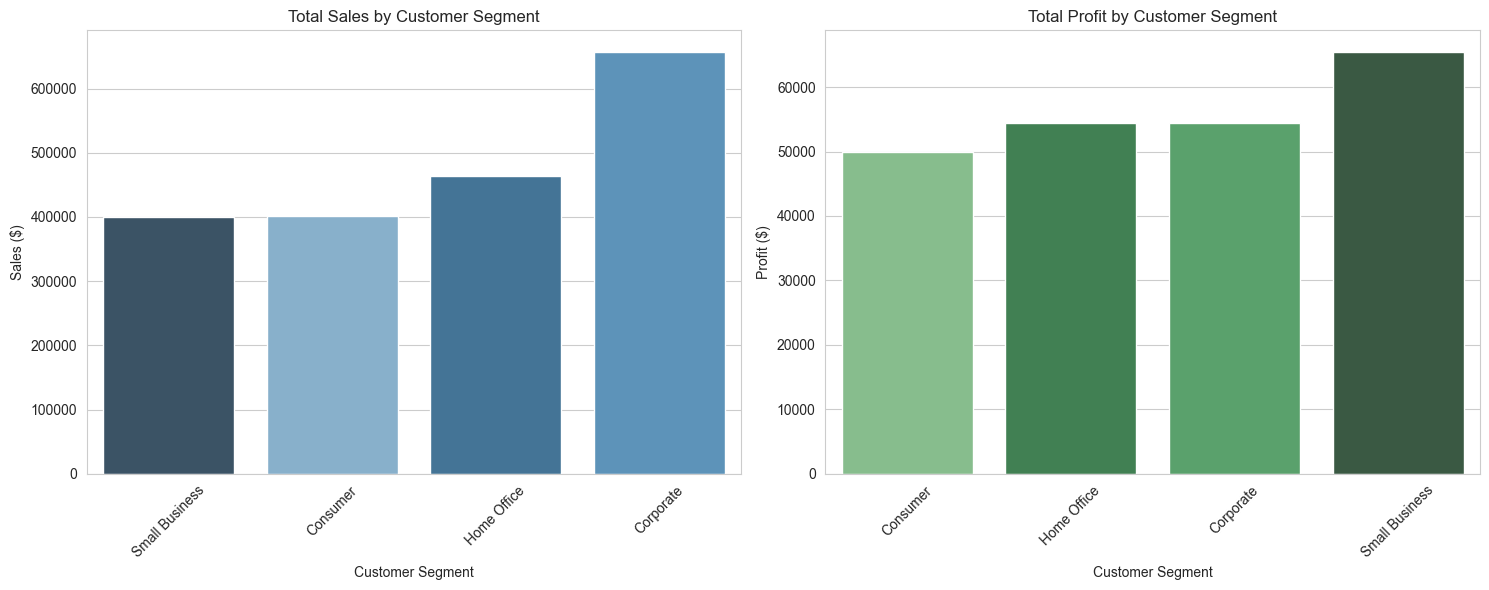

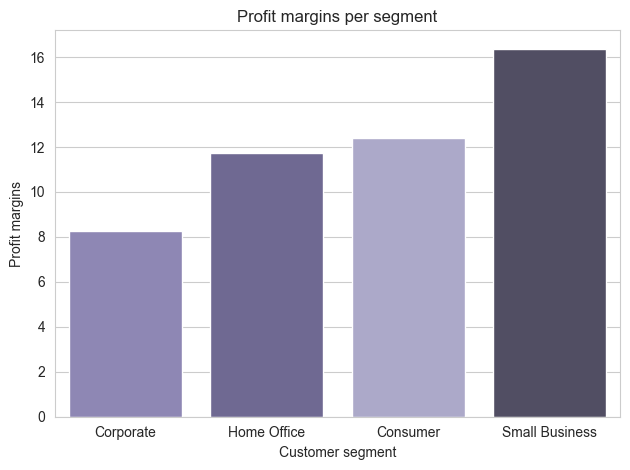


=== TOP 10 CUSTOMERS BY CLV ===
                                Total Sales Total Profit  Orders  \
Customer ID Customer Name                                          
693         Richard McClure      $15,269.70    $9,300.34       5   
2089        Annie Odom           $13,424.37    $9,243.26       3   
1734        Christopher Meadows  $15,224.63    $8,839.23       3   
1733        Nina Horne Kelly     $48,295.12    $8,533.43       3   
2781        Kelly Byers           $8,229.48    $7,495.06       3   
84          Helen Stein          $10,818.98    $7,257.76       2   
2507        Jeanette Davies      $10,180.01    $7,024.21       1   
627         Scott McKenna         $9,580.00    $6,610.20       1   
3397        Andrea Shaw           $9,603.24    $6,106.73       3   
2260        Geoffrey H Wong         $723.76    $5,998.03       4   

                                Avg Order Value          CLV  
Customer ID Customer Name                                     
693         Richard McCl

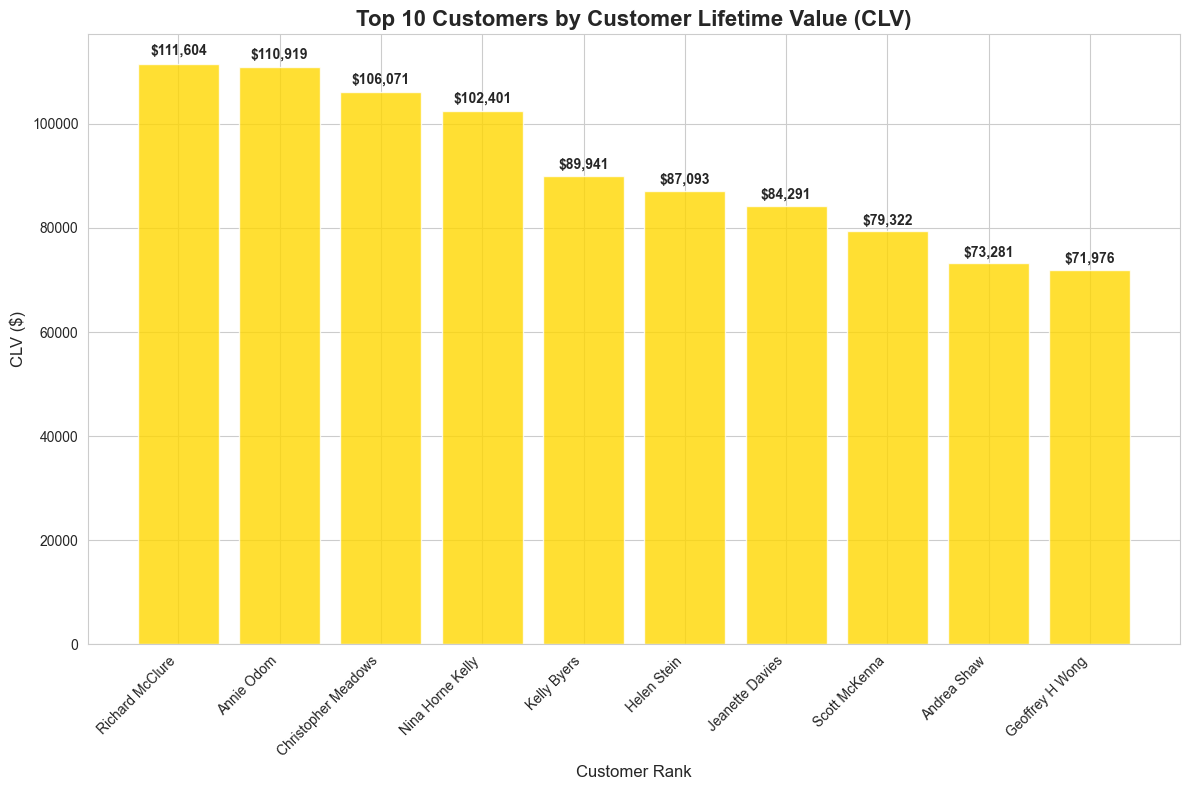

In [ ]:
# Visualize:
# - Bar chart: Sales and Profit by segment# Set style
sns.set_style("whitegrid")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Get the order for each chartsor
sales_order = profitable_segment.t_values('Sales').index.tolist()
profit_order = profitable_segment.sort_values('Profit').index.tolist()
margins_order = profitable_segment.sort_values('Profit Margin').index.tolist()

# Sales bar chart - Fixed version
sns.barplot(data=profitable_segment.reset_index(), x='Customer Segment', y='Sales', 
            hue='Customer Segment', ax=ax1, palette='Blues_d', order=sales_order, legend=False)
ax1.set_title('Total Sales by Customer Segment')
ax1.set_ylabel('Sales ($)')
ax1.tick_params(axis='x', rotation=45)

# Profit bar chart - Fixed version
sns.barplot(data=profitable_segment.reset_index(), x='Customer Segment', y='Profit', 
            hue='Customer Segment', ax=ax2, palette='Greens_d', order=profit_order, legend=False)
ax2.set_title('Total Profit by Customer Segment')
ax2.set_ylabel('Profit ($)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
# - Bar chart: Profit margins by segment
sns.barplot(data=profitable_segment.reset_index(), x='Customer Segment', y='Profit Margin',
            hue='Customer Segment',palette='Purples_d', order=margins_order, legend=False)
plt.title('Profit margins per segment')
plt.xlabel('Customer segment')
plt.ylabel('Profit margins')
plt.tight_layout()
plt.show()

# - Table or bar: Top customers by CLV
# Display table of top 10 customers by CLV
print("\n=== TOP 10 CUSTOMERS BY CLV ===")
clv_display = top_customer_by_clv[['Total_Sales', 'Total_Profit', 'Order_Count', 'Avg_Order_Value', 'CLV_Comprehensive']].copy()
clv_display.columns = ['Total Sales', 'Total Profit', 'Orders', 'Avg Order Value', 'CLV']

# Format for better display
for col in ['Total Sales', 'Total Profit', 'Avg Order Value', 'CLV']:
    clv_display[col] = clv_display[col].apply(lambda x: f"${x:,.2f}")

print(clv_display)

# Create bar chart for CLV
plt.figure(figsize=(12, 8))
top_10_clv = top_customer_by_clv.head(10)

# Create bar plot
bars = plt.bar(range(len(top_10_clv)), top_10_clv['CLV_Comprehensive'], color='gold', alpha=0.8)

# Customize the plot
plt.title('Top 10 Customers by Customer Lifetime Value (CLV)', fontsize=16, fontweight='bold')
plt.xlabel('Customer Rank', fontsize=12)
plt.ylabel('CLV ($)', fontsize=12)

# Add customer names on x-axis (rotated for readability)
customer_names = [name[1][:20] + '...' if len(name[1]) > 20 else name[1] for name in top_10_clv.index]
plt.xticks(range(len(top_10_clv)), customer_names, rotation=45, ha='right')

# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'${height:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


# Label plots clearly and use tight layouts

In [64]:
sns.heatmap(summary_df, annot=True, fmt='.2f', cmap='Blues')
plt.title('Customer Segment Profitability Dashboard')
plt.tight_layout()
plt.show()


NameError: name 'summary_df' is not defined